In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("/content/EV_charging_simulated_data.csv")
df.head()

,charger id,current,delta_current,voltage,delta_voltage,power (W),expected_load,status,location,temperature,class
0,101,15.2,0.5,480.1,1.1,7296.5,7300,CHARGING,"(40.71, -74.01)",35.5,0
1,102,0.0,0.0,0.0,0.0,0.0,0,IDLE,"(34.05, -118.24)",22.1,0
2,103,25.1,15.0,450.5,30.2,11300.0,8000,ERROR,"(51.51, -0.13)",65.9,1
3,104,18.0,-0.1,480.0,0.0,8640.0,8640,CHARGING,"(48.86, 2.35)",33.7,0
4,105,35.5,5.2,550.9,70.4,19550.0,10000,SAFE MODE,"(35.68, 139.69)",78.2,2


In [40]:
# Pre-Process the data -> keep only important features to classify the given event
df = df.drop(['charger id', 'location'], axis=1)
# Normalize status values to int -> [0, 1, 2, 3] = [IDLE, CHARGING, ERROR, SAFE MODE]
df['status'] = df['status'].map({
    'IDLE': 0,
    'CHARGING': 1,
    'OFF': 2,
    'SAFE MODE': 3,
    'ERROR': 4
})
df.head()

,current,delta_current,voltage,delta_voltage,power (W),expected_load,status,temperature,class
0,15.2,0.5,480.1,1.1,7296.5,7300,1,35.5,0
1,0.0,0.0,0.0,0.0,0.0,0,0,22.1,0
2,25.1,15.0,450.5,30.2,11300.0,8000,4,65.9,1
3,18.0,-0.1,480.0,0.0,8640.0,8640,1,33.7,0
4,35.5,5.2,550.9,70.4,19550.0,10000,3,78.2,2


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

target_class = df['class']
df = df.drop(['class'], axis=1)
data_train, data_test, target_train, target_test = train_test_split(df, target_class, test_size=0.2, random_state=1)

In [42]:
print("Training set shape ->", data_train.shape)
print("Test set shape ->", data_test.shape)

Training set shape -> (30408, 8)
Test set shape -> (7602, 8)


In [43]:
# Init the RFC Classifier
rfc = RandomForestClassifier(
    n_estimators=400,
    min_samples_leaf=2,   # try 2 then 3
    max_depth=18,
    class_weight="balanced",
    random_state=1,
    n_jobs=-1
)
rfc.fit(data_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_leaf=2, n_estimators=400, n_jobs=-1,
                       random_state=1)

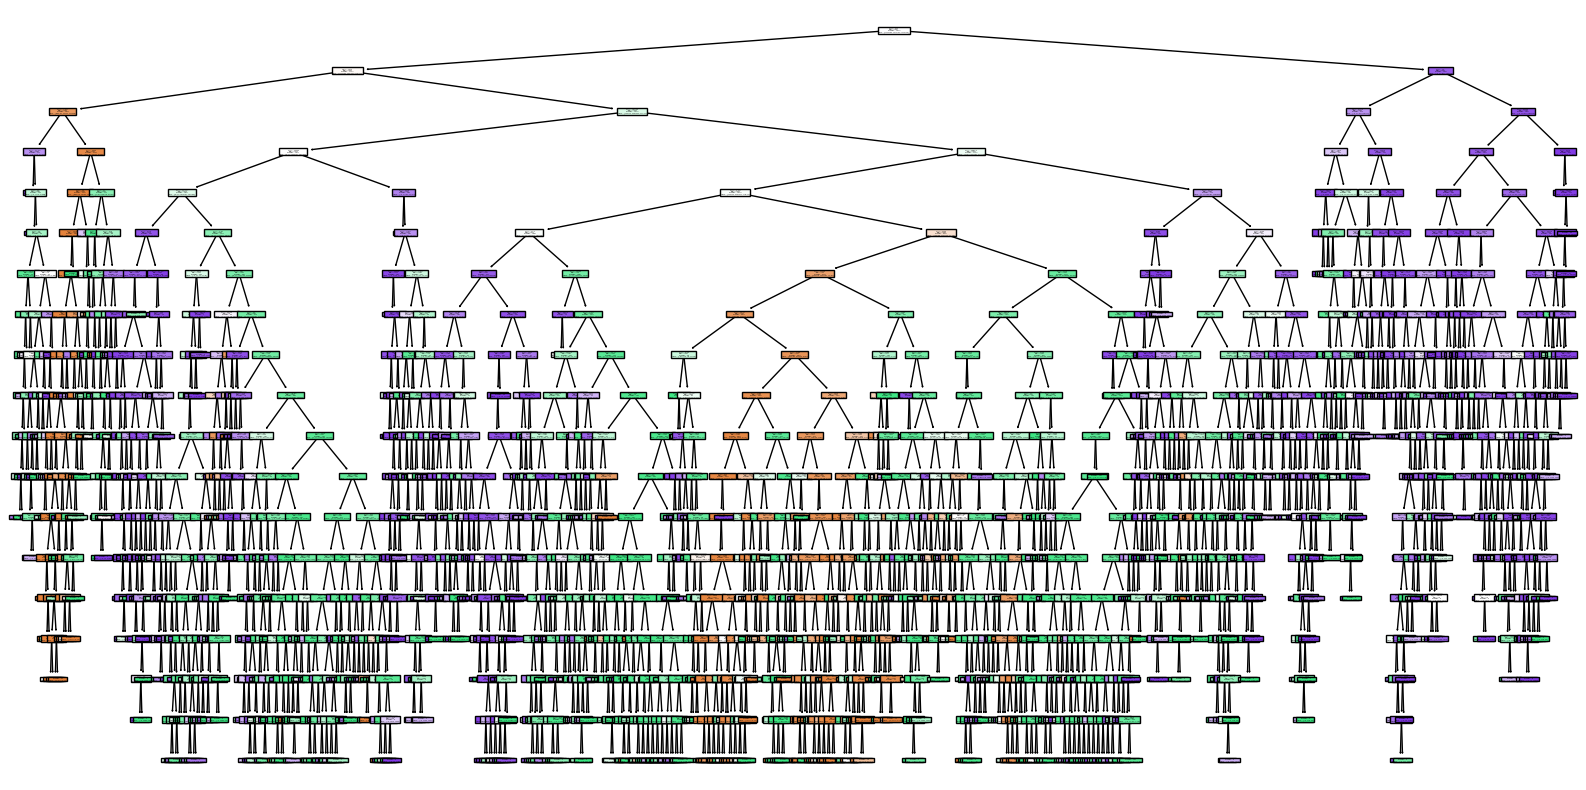

In [45]:
from sklearn import tree
plt.figure(figsize=(20,10))
tree.plot_tree(rfc.estimators_[0], filled=True)
plt.show()

In [46]:
# Predict the training set
train_predictions = rfc.predict(data_train)

In [47]:
# Predict the training set
test_predictions = rfc.predict(data_test)

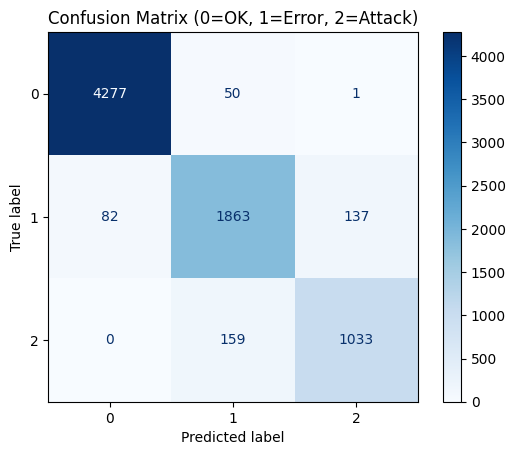

In [48]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    accuracy_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

# 1) Confusion matrix (most important)
cm = confusion_matrix(target_test, test_predictions, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (0=OK, 1=Error, 2=Attack)")
plt.show()

In [49]:
# 2) Per-class metrics + macro averages
print(classification_report(target_test, test_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9812    0.9882    0.9847      4328
           1     0.8991    0.8948    0.8970      2082
           2     0.8822    0.8666    0.8743      1192

    accuracy                         0.9436      7602
   macro avg     0.9208    0.9165    0.9187      7602
weighted avg     0.9432    0.9436    0.9434      7602



In [50]:
# 3) Key summary numbers (better than accuracy for your case)
acc = accuracy_score(target_test, test_predictions)
macro_f1 = f1_score(target_test, test_predictions, average="macro")
weighted_f1 = f1_score(target_test, test_predictions, average="weighted")

recall_per_class = recall_score(target_test, test_predictions, average=None, labels=[0,1,2])
precision_per_class = precision_score(target_test, test_predictions, average=None, labels=[0,1,2])

print("Accuracy:", round(acc,4))
print("Macro F1:", round(macro_f1,4))
print("Weighted F1:", round(weighted_f1,4))
print("Recall per class [0,1,2]:", np.round(recall_per_class,4))
print("Precision per class [0,1,2]:", np.round(precision_per_class,4))

Accuracy: 0.9436
Macro F1: 0.9187
Weighted F1: 0.9434
Recall per class [0,1,2]: [0.9882 0.8948 0.8666]
Precision per class [0,1,2]: [0.9812 0.8991 0.8822]
